In [77]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import skew


In [78]:
# Load the dataset
df = pd.read_csv('kp_updated (1).csv')  # Replace with your dataset path

# Initial exploration
print("Initial DataFrame Info:")
print(df.info())
print("\nNull values before cleaning:")
print(df.isnull().sum())

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 35 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Timestamp                                                            3034 non-null   object 
 1   Score                                                                0 non-null      float64
 2   Camp Date                                                            3034 non-null   object 
 3   Area                                                                 4435 non-null   object 
 4   Name                                                                 4432 non-null   object 
 5   Gender                                                               4435 non-null   object 
 6   National Id Card Number                                              2291 non-nu

In [79]:
# Drop unnecessary columns
columns_to_drop = ['Score', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Obesity']  # Adjust if needed
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Handle missing values (replace NaN and Inf)
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df.dropna(inplace=True)  # Drop rows with NaN values

In [80]:

# Ensure DataFrame is not empty
if df.empty:
    raise ValueError("DataFrame is empty after cleaning!")

# Split numerical and categorical columns
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)


Numerical Columns: []
Categorical Columns: ['Timestamp', 'Camp Date', 'Area', 'Name', 'Gender', 'National Id Card Number', 'Address', 'Contact Number ', 'Age', 'History of Diabetes', 'History of Hypertension', 'The patient was provided with Diabetes Awareness in the camp today.', 'Random Blood Sugar Reading', 'Blood Pressure Readings', 'Height', 'Weight', 'BMI', 'Cholesterol', 'HBA1c', 'Diet Chart given to the patient', 'Patient diagnosis', 'Patient Diagnosed with Hypertension', 'Patient Referred to Sugar Hospital', 'Eye Screening Notes', 'Foot Screening Notes', 'Dental Screening', 'Doctors Name', "Doctor's Notes", 'Medicines/Insulin Prescribed', 'Prescribed  Medicine Names ']


In [81]:

# Encode categorical columns
encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

In [82]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Numerical Columns to visualize outliers
# numerical_columns = [
#     'Age', 'Random Blood Sugar Reading', 'Blood Pressure Readings', 
#     'Height', 'Weight', 'BMI', 'Cholesterol', 'HBA1c', 
#     'Health Risk', 'BMI_Calculated'
# ]

# # Function to visualize outliers using a boxplot
# def visualize_outliers(data, columns):
#     for column in columns:
#         if column in data.columns:
#             plt.figure(figsize=(10, 6))
#             sns.boxplot(x=data[column])
#             plt.title(f'Boxplot for {column}')
#             plt.xlabel(column)
#             plt.show()

# # Visualize outliers
# visualize_outliers(df, numerical_columns)


In [83]:
# Handle outliers in numerical columns using IQR
def handle_outliers(data, column, method='cap'):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    if method == 'cap':
        data[column] = data[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return data

In [84]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Numerical Columns to visualize outliers
# numerical_columns = [
#     'Age', 'Random Blood Sugar Reading', 'Blood Pressure Readings', 
#     'Height', 'Weight', 'BMI', 'Cholesterol', 'HBA1c', 
#     'Health Risk', 'BMI_Calculated'
# ]

# # Function to visualize outliers using a boxplot
# def visualize_outliers(data, columns):
#     for column in columns:
#         if column in data.columns:
#             plt.figure(figsize=(10, 6))
#             sns.boxplot(x=data[column])
#             plt.title(f'Boxplot for {column}')
#             plt.xlabel(column)
#             plt.show()

# # Visualize outliers
# visualize_outliers(df, numerical_columns)


In [85]:

for column in numerical_columns:
    if column in df.columns:
        df = handle_outliers(df, column, method='cap')

In [86]:

# Transform skewed data
for column in numerical_columns:
    if column in df.columns:
        data = df[column].dropna()
        original_skewness = skew(data)
        if original_skewness > 0:
            df[column] = np.log1p(df[column])
        elif original_skewness < 0:
            df[column] = np.square(df[column])

In [87]:

# Create a health risk target column
bmi_threshold = 25  # Example threshold
cholesterol_threshold = 240  # Example threshold
hba1c_threshold = 6.5  # Example threshold

df['Health Risk'] = (
    (df['BMI'] > bmi_threshold) |
    (df['Cholesterol'] > cholesterol_threshold) |
    (df['HBA1c'] >= hba1c_threshold)
).astype(int)

In [88]:

# Ensure target column exists
if 'Health Risk' not in df.columns:
    raise ValueError("Target column 'Health Risk' is missing!")



In [89]:
# Split features and target
X = df.drop(columns='Health Risk')
y = df['Health Risk']

In [90]:
# Ensure valid data
if X.empty or y.empty:
    raise ValueError("Features or target data is empty!")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [91]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [92]:

# Ensure valid train-test split
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Unique values in y_train:", y_train.unique())





X_train shape: (342, 30)
y_train shape: (342,)
Unique values in y_train: [1 0]


In [93]:
# Initialize and train the model
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [94]:
# Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        86

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86


Confusion Matrix:
[[86]]


In [95]:
# Visualize outliers in numerical columns
def visualize_outliers(data, columns):
    for column in columns:
        if column in data.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data[column])
            plt.title(f'Boxplot for {column}')
            plt.xlabel(column)
            plt.show()

visualize_outliers(df, numerical_columns)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
data_path = 'kp_updated (1).csv'
df = pd.read_csv(data_path)

# Preprocessing
def preprocess_data(df):
    # Handle missing values
    df = df.fillna("Not Provided")

    # Standardize columns
    df['Camp Date'] = pd.to_datetime(df['Camp Date'], errors='coerce')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

    # Extract useful features
    df['Age Group'] = df['Age'].apply(lambda x: str(x).split(' ')[0] if pd.notnull(x) else 'Unknown')
    df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')

    # Encoding binary categories
    binary_cols = ['History of Diabetes', 'History of Hypertension', 
                   'The patient was provided with Diabetes Awareness in the camp today.', 
                   'Diet Chart given to the patient', 'Patient Diagnosed with Hypertension', 
                   'Patient Referred to Sugar Hospital']
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Not Provided': -1})

    # Target variable encoding
    df['Target'] = df['Patient Diagnosed with Hypertension'].fillna(0)
    return df

df = preprocess_data(df)

# Feature selection
features = ['BMI', 'Age Group', 'History of Diabetes', 'History of Hypertension', 
            'Diet Chart given to the patient', 'Random Blood Sugar Reading']
df = df.dropna(subset=features)
X = pd.get_dummies(df[features], drop_first=True)
y = df['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.9230769230769231
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         2
         0.0       0.90      0.94      0.92        67
         1.0       0.95      0.93      0.94        74

    accuracy                           0.92       143
   macro avg       0.62      0.62      0.62       143
weighted avg       0.91      0.92      0.92       143



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
# from sklearn.preprocessing import StandardScaler, LabelEncoder

# # Handling missing values (e.g., mean imputation for numeric features)
# df.fillna(df.mean(), inplace=True)

# # Encode categorical variables (assuming 'sex' and 'thal' are categorical)
# label_encoder = LabelEncoder()
# df['sex'] = label_encoder.fit_transform(df['sex'])
# df['thal'] = label_encoder.fit_transform(df['thal'])

# # Feature scaling
# scaler = StandardScaler()
# numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# # Check processed data
# print(df.head())


Dataset Overview:
          Timestamp  Score  Camp Date         Area          Name Gender  \
0  1/23/2024 21:37    NaN  1/23/2024      Regi 01    Raza Hasan   Male   
1  1/24/2024 15:11    NaN  1/24/2024      Regi 01           ABC   Male   
2  1/25/2024 12:01    NaN  1/21/2024  Chamkini 02    Nasarullah   Male   
3  1/25/2024 12:08    NaN  1/21/2024  Chamkini 02  Abdul Sattar   Male   
4  1/25/2024 12:12    NaN  1/21/2024  Chamkini 02        Khadim   Male   

  National Id Card Number    Address Contact Number        Age  ...  \
0      hdf123-332-222-333       Regi             NaN   51 - 60  ...   
1             51669923450       Regi       920104567   31 - 40  ...   
2                    nill  Chamkini       3179570829   41 - 50  ...   
3                     Nil   Chamkani      3171919625   51 - 60  ...   
4                     NaN   Chamkini      3005855570  above 60  ...   

  Foot Screening Notes Dental Screening                       Doctors Name  \
0                  yes         

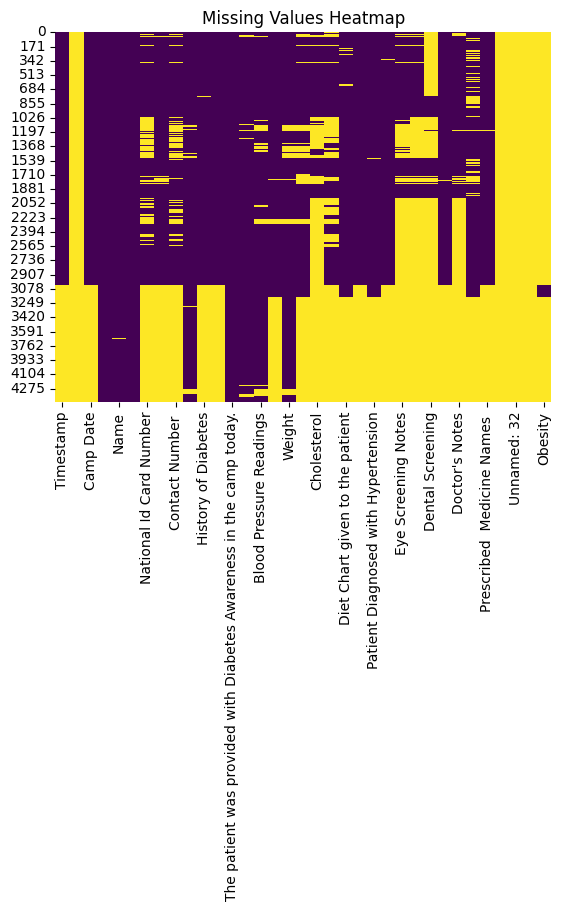

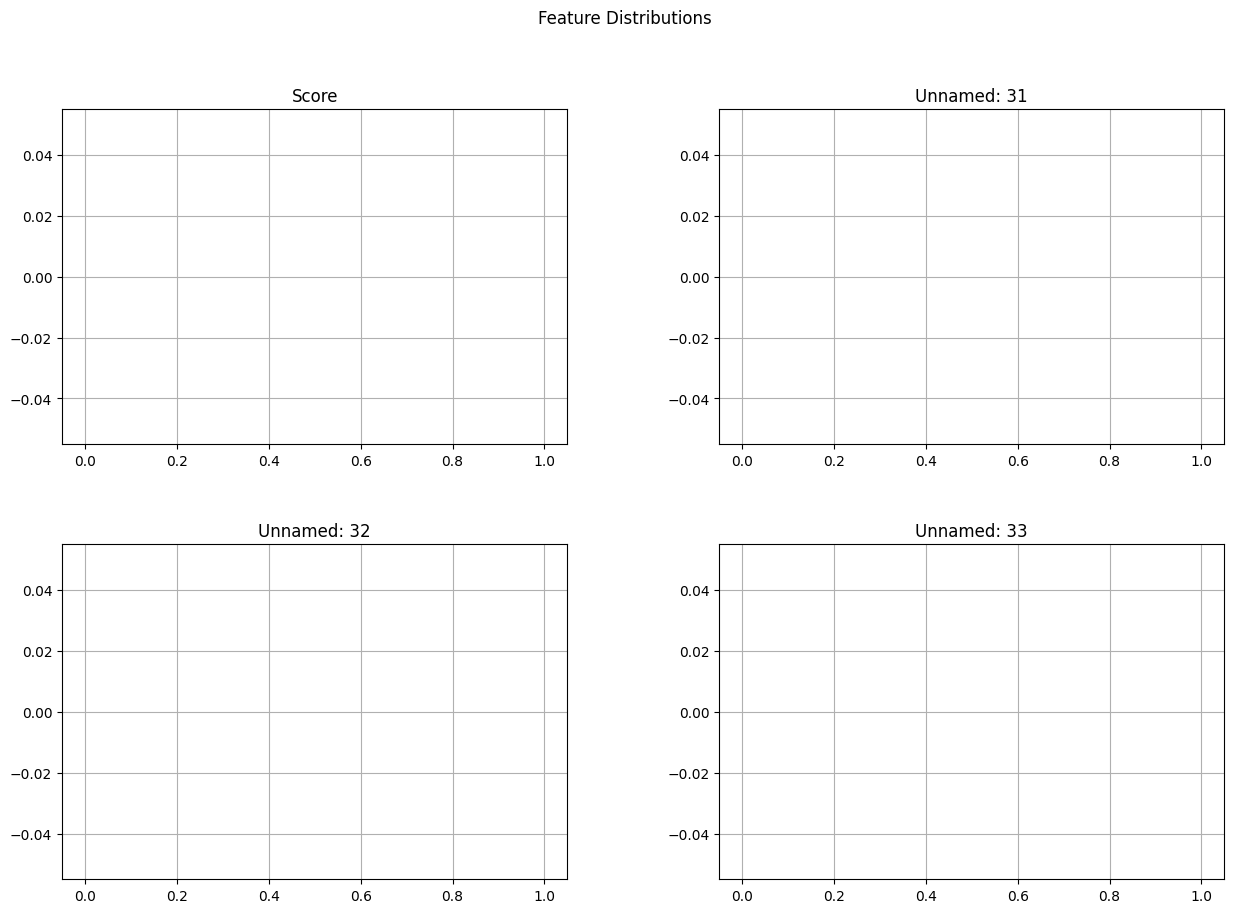

ValueError: could not convert string to float: '1/23/2024 21:37'

<Figure size 1200x800 with 0 Axes>

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix, roc_auc_score
from statsmodels.tsa.arima.model import ARIMA

# Load Dataset
data_path = "kp_updated (1).csv"  # Replace with the actual dataset path
df = pd.read_csv(data_path)

# 1. Exploratory Data Analysis
print("Dataset Overview:\n", df.head())
print("\nDataset Info:\n")
df.info()
print("\nSummary Statistics:\n", df.describe())

# Visualize Missing Values
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Distributions of Key Features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 2. Data Preprocessing
# Handling Missing Values
imputer = SimpleImputer(strategy="mean")
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# Encoding Categorical Features
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Scaling Numerical Features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 3. Feature Engineering
# Example: Create BMI categories and thresholds for HbA1c levels
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 24.9:
        return "Normal"
    elif 25 <= bmi < 29.9:
        return "Overweight"
    else:
        return "Obese"

def categorize_hba1c(hba1c):
    if hba1c < 5.7:
        return "Normal"
    elif 5.7 <= hba1c < 6.5:
        return "Prediabetic"
    else:
        return "Diabetic"

df['BMI_Category'] = df['BMI'].apply(categorize_bmi)
df['HbA1c_Category'] = df['HbA1c'].apply(categorize_hba1c)

# Encoding New Categorical Features
df['BMI_Category'] = encoder.fit_transform(df['BMI_Category'])
df['HbA1c_Category'] = encoder.fit_transform(df['HbA1c_Category'])

# Feature: Risk Threshold
# Creating thresholds for high-risk patients based on multiple conditions
def determine_risk(row):
    if row['HbA1c'] > 6.5 and row['BMI'] > 30 and row['Age'] > 50:
        return "High Risk"
    elif row['HbA1c'] > 6.5 or row['BMI'] > 30:
        return "Medium Risk"
    else:
        return "Low Risk"

df['Risk_Category'] = df.apply(determine_risk, axis=1)
df['Risk_Category'] = encoder.fit_transform(df['Risk_Category'])

# 4. Predictive Modeling
# Split Data
X = df.drop(['target_column', 'Patient_ID'], axis=1, errors='ignore')  # Replace 'target_column' with the target
y = df['target_column']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f"Random Forest ROC-AUC Score: {roc_auc_rf}")

# Train a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
roc_auc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print(f"Gradient Boosting ROC-AUC Score: {roc_auc_gb}")

# 5. Clustering
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)
df['Cluster'] = clusters

# Silhouette Score
sil_score = silhouette_score(X, clusters)
print(f"Silhouette Score: {sil_score}")

# Visualize Clusters
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters, cmap="viridis")
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# 6. Time-Series Analysis
# Example: HbA1c Trend Prediction (Replace 'HbA1c' with the actual column name)
if 'HbA1c' in df.columns:
    hba1c_data = df['HbA1c'][:100]  # Example: First 100 entries
    model = ARIMA(hba1c_data, order=(1, 1, 1))
    arima_result = model.fit()
    print(arima_result.summary())

    # Forecast
    forecast = arima_result.forecast(steps=10)
    plt.plot(range(len(hba1c_data)), hba1c_data, label="Actual")
    plt.plot(range(len(hba1c_data), len(hba1c_data) + 10), forecast, label="Forecast")
    plt.legend()
    plt.title("HbA1c Trend Forecast")
    plt.show()
